In [1]:
# Library imports
from helpers_NLP import *

import warnings
warnings.filterwarnings("ignore")

/home/tfc/anaconda3/envs/mental_health/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Detecting Psychological Distress in Online Forum Posts: An Exploration of Different Machine Learning Techniques

## Table of Contents

1. [Background](#Background)
2. [Approach](#Approach)
3. [PRAW - Reddit API for Text Post Retrieval](#PRAW)
4. [Classical Machine Learning Models](#Classical-Machine-Learning-Models)
    1. [Preprocessing](#Preprocessing-for-classical-models)
    2. [Model Training Flow - Naive Bayes](#Typical-Model-Training-Flow---Naive-Bayes-Example)
    3. [Model Training - Naive Bayes and Logistic Regression](#Training-Multinomial-NB-and-Logistic-Regression)
    4. [Model Training - XGBoost](#Training-XGBoost)
5. [Deep Learning - BERT](#Deep-Learning---BERT)
    1. [Preprocessing](#Preprocessing-for-BERT)
    2. [Model Training](#Training-BERT)
    3. [ONNX Format](#ONNX-Format)
6. [Evaluation and Model Comparison](#Evaluation-and-Model-Comparison)
7. [Conclusion and Future Work](#Conclusion-and-Future-Work)

## Background

Recent years have seen a worrying rise in emotional distress among youths, prompting many to turn to online forums and social media platforms for support. A text classification machine learning program aimed at sifting through copious text posts on these platforms for signs of emotional distress can allow timely intervention. In this project, a range of machine learning techniques are explored for this task, including Naive Bayes, Logistic Regression, and XGBoost, combined with various vectorization methods such as Count Vectorizers and Word2Vec. For comparison, a BERT-based model is also built, which has shown superior predictive performance compared to traditional models, albeit with increased computational demands during both training and inference phases. The best model to deploy will ultimately depend on use case and consider such trade-offs between accuracy and feasibility.

## Approach

Text posts from a subreddit on mental health [r\mentalhealth](https://www.reddit.com/r/mentalhealth/) and on casual conversations [r\casualconversation](https://www.reddit.com/r/CasualConversation/) are used for training these models, with the former representing posts showing signs of emotional distress, and the latter for posts without such signs. The PRAW package is used to retrieve these posts via the reddit API. Unfortunately, there is a retrieval limit of 1000 posts from each subreddit, hindering the potential of such models to achieve good predictive capabilities. Nonetheless, the models trained here present reasonable accuracy. A simple app is created on streamlit as a proof of concept for deployment, which includes API calls for more recent reddit text posts. A similar methodology can be employed for other social media platforms or online forums.

To reduce clutter in this notebook, helper functions are placed in __helpers_NLP.py__ and imported as shown above.


## PRAW

To begin, the text posts required are scraped from the relevant subreddits for training a binary classification model, i.e. r\mentalhealth for positive cases and r\casualconversation for the negative cases. The next cell makes multiple API calls and could take a long time to run. Note that the `client_id`, `client_secret` and `user_agent` arguments should be provided for the cell to run.

In [2]:
from dotenv import load_dotenv

# Define data path and API settings
data_path = './data/'
load_dotenv()
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
USER_AGENT = os.getenv("USER_AGENT")

# Download up to 1000 posts from mentalhealth subreddit
menhealth_posts = get_reddit_posts2(sub_reddit = 'mentalhealth', client_id = CLIENT_ID, client_secret = CLIENT_SECRET,
                             user_agent = USER_AGENT, post_type = 'new',nsfw = True)
menhealth_posts,menhealth_post_texts = get_post_texts2(menhealth_posts,get_all_comments=True)

# Extract relevant information from each post, create dataframe and export as CSV
df_mh = make_df_with_url(menhealth_posts,menhealth_post_texts,category_name='new')
df_mh.to_csv(os.path.join(data_path,'Subreddit_mentalhealth.csv'))

# Repeat for casual conversation subreddit
casconv_posts = get_reddit_posts2(sub_reddit = 'casualconversation', client_id = None, client_secret = None,
                             user_agent = None, post_type = 'new',nsfw = True)
casconv_posts,casconv_post_texts = get_post_texts2(casconv_posts,get_all_comments=True)

df_cc = make_df_with_url(casconv_posts,casconv_post_texts,category_name='new')
df_cc.to_csv(os.path.join(data_path,'Subreddit_casualconversation.csv'))

Alternatively, run the following cell to use pre-scaped data.

In [3]:
# Local paths for data. Run to retrieve saved csvs.
data_path = './data/'
mentalhealth_path = os.path.join(data_path,'subreddit_mentalhealth.csv')
casualconversation_path = os.path.join(data_path,'subreddit_casualconversation.csv')

# Load csv as dataframes and set target/label accordingly
df_mh = pd.read_csv(mentalhealth_path)
df_cc = pd.read_csv(casualconversation_path)

In [4]:
# Set target/label accordingly
df_mh['target'] = 'mentalhealth'
df_cc['target'] = 'casualconversation'

# Combine dataframes as single dataset with labels.
df_raw = pd.concat([df_mh,df_cc])
try:
    df_raw.drop(columns=['Unnamed: 0'],inplace=True)
except:
    pass
df_raw.drop_duplicates(subset=['id'],keep='first',inplace=True)
df_raw.reset_index(drop=True,inplace=True)

# Processing to strip texts 
df_raw['comments'] = df_raw['comments'].str.lstrip('[').str.rstrip(']').str.lstrip('\'').str.rstrip('\'').str.lstrip('\"').str.rstrip('\"')
df_raw['comments'] = df_raw['comments'].replace('', np.nan)
df_raw[['title','body','comments']] = df_raw[['title','body','comments']].fillna('')

# Check for class imbalance. Looks ok.
df_raw.target.value_counts()

target
mentalhealth          1010
casualconversation     977
Name: count, dtype: int64

In [5]:
# Check data structure
display(df_raw.sample(5,random_state=42))

,id,title,body,score,num_comments,category,comments,url,target
212,1deunja,Dealing with Anxiety,"Hi everyone, \nLately, I've been feeling real...",1,1,new,,https://www.reddit.com/r/mentalhealth/comments...,mentalhealth
1517,1d9tkmt,Hello,Hi! I am new here. Maybe I could use some help...,0,4,new,Hi! Welcome!\n\nThis is really just a place fo...,https://www.reddit.com/r/CasualConversation/co...,casualconversation
785,1dcwihw,How to heal after SA?,I just feel so exhausted all the time. It’s be...,1,1,new,**Hello u/!** \n\nThank you for tagging this p...,https://www.reddit.com/r/mentalhealth/comments...,mentalhealth
1175,1ddqewx,Do you have a favorite time?,This might sound crazy but mine is 21:50 and f...,6,12,new,11:11. It was one of my favorite teachers favo...,https://www.reddit.com/r/CasualConversation/co...,casualconversation
1760,1d74qj2,What is the happiest year of your life so far?,I can still recall how I was so blessed and tr...,28,45,new,Probably the ones I don't remember anymore (sc...,https://www.reddit.com/r/CasualConversation/co...,casualconversation


In [6]:
# Show sample of each category
print('Positive posts (with signs of emotional distress):')
print(df_mh.sample(random_state=42)['body'].values[0])

print('\n\n\nNegative posts (casual conversation):')
print(df_cc.sample(random_state=42)['body'].values[0])


Positive posts (with signs of emotional distress):
Just wondered if anyone has tried this treatment for depression or other mental health issues and found success or had any side effects?

I’d be curious to know how people have found it, that’s if there’s anyone on here who’s tried it?



Negative posts (casual conversation):
I just turned 28.

I may have learned a lot of lessons during my 20s, but I feel like I'm getting too old to put any of them to use.

I think it's because I don't have any idea of what people's 30s usually look like, especially compared to their 20s.

Would like to hear your stories.


## Classical Machine Learning Models

We first compare different classical machine learning models for the task at hand, including multinomial Naive Bayes, K-Nearest Neighbors (KNN), Logistic Regression, and XGBoost. For Natural Language Processing (NLP) using non deep learning approaches, data prepping is typically done to convert text sequences representations that can be used for training. We explore the use of count vectorizers, TIDF, word2vec, fasttext and Doc2Vec here.

### Preprocessing for Classical Models
First, we preprocess the text sequences by removing punctuation, removing stop words, and performing stemming. Then, the title, body, and all comments and replies of each entry are combined into a single text chunk for classification, stored as the `alltext` feature. This is done using the `preprocess_regular` function below, which also prints the number of instances in each class as shown below to check for class imbalance. The data is then split into train and test sets.

Remark: As text posts can vary greatly in length, we may want to split long sequences into multiple shorter ones to provide more training examples for the given label. This is achieved through the `split_length` option of the `preprocess_regular` function. The `id_train` and `id_test` values below are required for tracking labels if splitting is done. Through experimentation, the traditional machine learning models appear to perform best on this dataset __without__ any splitting. Therefore, no splitting is performed in the example provided here.

In [7]:
# Preprocess text and show sample size in each category
df = preprocess_regular(df_raw, min_num_words=None,split_length=None,remove_punc=True)

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(df['alltext'],
                                                    df['target'],
                                                    test_size=0.2,
                                                    stratify=df['target'],
                                                    random_state=42)

# Retain ids for later reference if text splitting is done.
id_train, id_test = train_test_split(df['id'],
                                     test_size=0.2,
                                     stratify=df['target'],
                                     random_state=42)

target
1    1010
0     977
Name: count, dtype: int64

`CountVectorizer` is used to provide a quick idea on vocabulary size of our dataset, showing that there are 33148 unique tokens/words in the train dataset.

In [8]:
# CountVectorizer for unigram. To get an idea of vocab size
count_vect = CountVectorizer()                                     # Initialize CountVectorizer
X_train_temp = count_vect.fit_transform(X_train)                   # Fit transform train set
X_test_temp = count_vect.transform(X_test)                         # Transform test set

print(f'Vocabulary size: {X_train_temp.shape[1]}')

Vocabulary size: 33179


### Typical Model Training Flow - Naive Bayes Example

Model training is commonly done using a pipeline to perform any preprocessing required before the training data is passed to the model. Furthermore, various hyperparameter values can be experimented with using grid search to identify the best values to use. The multinomial Naive Bayes model is used here to demonstrate this modelling flow. The predictive performance of the trained model is also shown below in the form of a confusion matrix and a classification report displaying various relevant metrics.

Remark: For cases where a long text sequence in a text post is split into multiple sequences, there is a need to combine the predictions from multiple child sequences during inference to classify a post. Here, this is done by taking the mean of the predicted probability values of the child sequences, performed using the `combine_preds_regular` function. as mentioned earlier, this splitting is not done in the current example, but is kept as an option for the interested user.

In [9]:
# General pipeline for fitting to Naive Bayes model
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Parameters for gridsearch CV
pipe_params = {
    'cvec__max_features': [10000, 20000, 30000, 40000],       # Maximum number of features allowed
    'cvec__min_df': [2, 3],                                   # Minimum number of times word must appear in the documents to be included in vocab
    'cvec__max_df': [.9, .95],                                # Maximum number of times word can appear in the documents to be included in vocab
    'cvec__ngram_range': [(1,1), (1,2)]                       # Range of ngram sizes considered
}

# Fit model
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  verbose=0,
                  cv=5) # 5-fold cross-validation.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [10000, 20000, 30000, 40000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [10]:
# Quick view of model accuracy and best ngram range selected
print(f'Train set accuracy: {gs.score(X_train, y_train)}')
print(f'Test set accuracy: {gs.score(X_test, y_test)}')
best_countvectorizer = gs.best_estimator_.named_steps['cvec']
print(f'Best ngram range selected: {best_countvectorizer.ngram_range}')

Train set accuracy: 0.9723096286972939
Test set accuracy: 0.9371859296482412
Best ngram range selected: (1, 2)


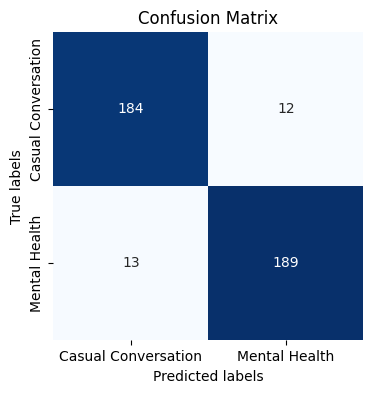

Classification Report:
                      precision    recall  f1-score   support

Casual Conversation       0.93      0.94      0.94       196
      Mental Health       0.94      0.94      0.94       202

           accuracy                           0.94       398
          macro avg       0.94      0.94      0.94       398
       weighted avg       0.94      0.94      0.94       398



In [11]:
# Get predictions
pred_proba = gs.predict_proba(X_test)
y_test_grouped, y_pred_grouped = combine_preds_regular(pred_proba,id_test,y_test)

# Generate confusion matrix and classification report
create_confusion_matrix_and_class_report(y_test_grouped, y_pred_grouped,make_confusion=True)

In anticipation of later model evaluation, we prep an empty dictionary `f1_scores` to store the f1_scores of the different models.

In [12]:
# Collect F1-score for each model
f1_scores = {}

### Training Multinomial NB and Logistic Regression
The same procedure above is performed for each combination of traditional machine learning models (except XGBoost) and vectorization technique below. The trained models are saved for later reference. CountVectorizer and TfidfVectorizer are used for all models, while Word2Vec, Doc2Vec, and FastText are applied only for the logistic regression model.

In [13]:
# Model save location
model_path = 'models/'

# Define vectorizers and their parameters
vectorizers = {
    'CountVectorizer': (CountVectorizer(), {
        'max_features': [10000, 20000, 30000, 40000],
        'min_df': [2, 3],
        'max_df': [0.9, 0.95],
        'ngram_range': [(1, 1), (1, 2)]
    }),
    'TfidfVectorizer': (TfidfVectorizer(), {
        'max_features': [10000, 20000, 30000, 40000],
        'min_df': [2, 3],
        'max_df': [0.9, 0.95],
        'ngram_range': [(1, 1), (1, 2)]
    })
}

# Define models and their parameters
models = {
    'MultinomialNB': (MultinomialNB(), {})
}

# Perform GridSearchCV for each combination
for vec_name, (vectorizer, vec_params) in vectorizers.items():
    for model_name, (model, model_params) in models.items():
        print(f'Training {model_name} using {vec_name}')
        pipe = Pipeline([
            (vec_name.lower(), vectorizer),
            (model_name.lower(), model)
        ])
        pipe_params = {f'{vec_name.lower()}__{k}': v for k, v in vec_params.items()}
        pipe_params.update({f'{model_name.lower()}__{k}': v for k, v in model_params.items()})

        gs = GridSearchCV(pipe, param_grid=pipe_params, verbose=0, cv=5)
        gs.fit(X_train, y_train)

        # Make prediction and get F1 score.
        mod_name = f'{model_name}_{vec_name}'             # Create model name
        pred_proba = gs.predict_proba(X_test)
        y_test_grouped, y_pred_grouped = combine_preds_regular(pred_proba,id_test,y_test)

        # Generate classification report
        report = create_confusion_matrix_and_class_report(y_test_grouped, y_pred_grouped,make_confusion=False,output_dict=True)
        f1_scores[mod_name] = report['Mental Health']['f1-score']
        print(f'{mod_name} F1 score: {f1_scores[mod_name]}\n')

        # Save best model
        model_filename = mod_name+'.pkl'
        with open(os.path.join(model_path,model_filename), 'wb') as f:
            pickle.dump(gs.best_estimator_, f)

Training MultinomialNB using CountVectorizer
MultinomialNB_CountVectorizer F1 score: 0.9379652605459057

Training MultinomialNB using TfidfVectorizer
MultinomialNB_TfidfVectorizer F1 score: 0.9468599033816425



In [14]:
# Model save location
model_path = 'models/'

# Define vectorizers and their parameters
vectorizers = {
    'CountVectorizer': (CountVectorizer(), {
        'max_features': [10000, 20000, 30000, 40000],
        'min_df': [2, 3],
        'max_df': [0.9, 0.95],
        'ngram_range': [(1, 1), (1, 2)]
    }),
    'TfidfVectorizer': (TfidfVectorizer(), {
        'max_features': [10000, 20000, 30000, 40000],
        'min_df': [2, 3],
        'max_df': [0.9, 0.95],
        'ngram_range': [(1, 1), (1, 2)]
    }),
    'Word2Vec': (Word2VecVectorizer(), {
        'size': [100, 200, 300],
        'window': [5, 10],
        'min_count': [1, 2]
    }),
    'FastText': (FastTextVectorizer(), {
        'size': [100, 200, 300],
        'window': [5, 10],
        'min_count': [1, 2]
    }),
    'Doc2Vec': (Doc2VecVectorizer(), {
        'vector_size': [100, 200, 300],
        'window': [5, 10],
        'min_count': [1, 2]
    })
}

# Define models and their parameters
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.01, 0.1, 1, 10]
    })
}

# Perform GridSearchCV for each combination
for vec_name, (vectorizer, vec_params) in vectorizers.items():
    for model_name, (model, model_params) in models.items():
        print(f'Training {model_name} using {vec_name}')
        pipe = Pipeline([
            (vec_name.lower(), vectorizer),
            # ('scaler', StandardScaler()),
            (model_name.lower(), model)
        ])
        pipe_params = {f'{vec_name.lower()}__{k}': v for k, v in vec_params.items()}
        pipe_params.update({f'{model_name.lower()}__{k}': v for k, v in model_params.items()})

        gs = GridSearchCV(pipe, param_grid=pipe_params, verbose=0, cv=5)
        gs.fit(X_train, y_train)

        # Make prediction and get F1 score.
        mod_name = f'{model_name}_{vec_name}'             # Create model name
        pred_proba = gs.predict_proba(X_test)
        y_test_grouped, y_pred_grouped = combine_preds_regular(pred_proba,id_test,y_test)

        # Generate classification report
        report = create_confusion_matrix_and_class_report(y_test_grouped, y_pred_grouped,make_confusion=False,output_dict=True)
        f1_scores[mod_name] = report['Mental Health']['f1-score']
        print(f'{mod_name} F1 score: {f1_scores[mod_name]}\n')

        # Save best model
        model_filename = mod_name+'.pkl'
        with open(os.path.join(model_path,model_filename), 'wb') as f:
            pickle.dump(gs.best_estimator_, f)

Training LogisticRegression using CountVectorizer
LogisticRegression_CountVectorizer F1 score: 0.9164677804295943

Training LogisticRegression using TfidfVectorizer
LogisticRegression_TfidfVectorizer F1 score: 0.9466019417475728

Training LogisticRegression using Word2Vec
LogisticRegression_Word2Vec F1 score: 0.905940594059406

Training LogisticRegression using FastText
LogisticRegression_FastText F1 score: 0.9310344827586207

Training LogisticRegression using Doc2Vec
LogisticRegression_Doc2Vec F1 score: 0.88



### Training XGBoost

Based on findings shown above, `TfidfVectorizer` appears to provide the best results for this dataset. For simplicity, the XGBoost model will only be trained on TfidfVectorizer, using the same parameters as that used for the Multinomial NB model. The performance metrics are similarly shown below.

In [15]:
with open(os.path.join(model_path,'MultinomialNB_TfidfVectorizer.pkl'),'rb') as f:
    MNB_tfidf = pickle.load(f)
MNB_tfidf.get_params()['steps'][0][1]

TfidfVectorizer(max_df=0.9, max_features=20000, min_df=2, ngram_range=(1, 2))

In [16]:
# Model save location
model_path = 'models/'

# Pipeline for XGBoost with TfidfVectorizer
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_df=0.9, max_features=20000, min_df=3, ngram_range=(1, 2))),
    ('sort_indices', SortIndicesAndConvertToTensor()),
    ('classifier', XGBClassifier(tree_method="hist", device='cuda', use_label_encoder=False, 
                                 n_estimators=5000, max_depth=6, learning_rate=0.05, eval_metric='error')),
])

# Fit the model
pipeline.fit(X_train, y_train)

# Save XGBooost model
with open(os.path.join(model_path,'XGBoost_TfidfVectorizer.pkl'),'wb') as f:
    pickle.dump(pipeline,f)

Alternatively, load the trained model below.

In [17]:
# Load XGBoost model.
with open(os.path.join(model_path,'XGBoost_TfidfVectorizer.pkl'),'rb') as f:
    pipeline = pickle.load(f)

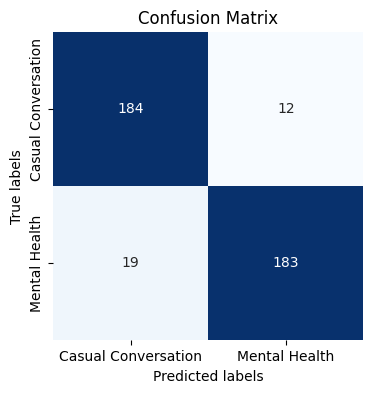

XGBoost_TfidfVectorizer F1 score: 0.9219143576826196



In [18]:
# Evaluate the model on the test set
pred_proba = pipeline.predict_proba(X_test)
y_test_grouped, y_pred_grouped = combine_preds_regular(pred_proba,id_test,y_test)
report = create_confusion_matrix_and_class_report(y_test_grouped, y_pred_grouped,make_confusion=True,output_dict=True)
f1_scores['XGBoost_TfidfVectorizer'] = report['Mental Health']['f1-score']
print(f'XGBoost_TfidfVectorizer F1 score: {f1_scores['XGBoost_TfidfVectorizer']}\n')

## Deep Learning - BERT
Deep strides have been made in NLP with the introduction of attention mechanisms and transformers. Of these, a pretrained-BERT model (available on huggingface) is selected for further training here.

### Preprocessing for BERT

The preprocessing required for BERT models is different from that performed for traditional machine learning models. In particular, stemming and stop word removals are not needed, as text embeddings are already available in the pre-trained model. Similar to preprocessing performed for the previous models, the title, body, and all comments and replies of each entry are combined into a single text chunk for classification, stored as the `alltext` feature. The `preprocess_BERT` function below is used simple cleaning purposes.

Remark: In contrast to the models presented earlier, the BERT model grows quadratically with sequence length. As such, longer text sequences are split into child sequences of approximately 500 word lengths.

In [19]:
# Preprocess text data for BERT and print number of samples in each category.
# Note that the inflated sample size shown below is a consequence of splitting long texts sequences into multiple shorter ones.
df = preprocess_BERT(df_raw,min_num_words=20,split_length=500)

# Train test split
X_train, X_test = train_test_split(df.drop(columns='id'), test_size=0.2,
                                   random_state=42,
                                   stratify=df['target'])                      # Train test split

# Retain ids for later reference
id_train, id_test = train_test_split(df['id'],
                                     test_size=0.2,
                                     stratify=df['target'],
                                     random_state=42)

# Create dataloaders
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
dataset_dict = create_dataset_dict(tokenizer, X_test, X_train=X_train)
train_dataloader = DataLoader(dataset_dict['train'], shuffle=True, batch_size=16)
test_dataloader = DataLoader(dataset_dict['test'], batch_size=16)

target
0    2988
1    1404
Name: count, dtype: int64

### Training BERT

The BERT model is then loaded and trained following HuggingFace protocols. The model performance is shown in the confusion matrix and classification matrix below.

In [20]:
# Set up model
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased",
                                                           num_labels=2)

# Select optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Set up training rules including number of epochs and learning rate scheduler.
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Train on cuda if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [21]:
# Model save location
model_path = 'models/'

# Start training
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}", dynamic_ncols=True, leave=True)

    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Update progress bar description with current loss
        progress_bar.set_postfix(loss=loss.item())
        
        # Manually flush the progress bar
        progress_bar.update()

# Save model
model_name = 'BERT_reddit.pth'
torch.save(model.state_dict(), os.path.join(model_path,model_name))

Epoch 3/3: 100%|██████████| 220/220 [00:41<00:00,  5.29it/s, loss=0.00257] 


Alternatively, load the trained model below.

In [22]:
# Load saved model
model_name = 'BERT_reddit.pth'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.load_state_dict(torch.load(os.path.join(model_path,model_name),map_location=device))

<All keys matched successfully>

In [23]:
# Predicting on test set and getting logits.
model.eval()
preds = []
preds_logits = []
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    preds_logits.append(logits)
    predictions = torch.argmax(logits, dim=-1)
    preds.append(predictions)
preds_logits = torch.cat(preds_logits).cpu().numpy()
preds_proba = 1 / (1 + np.exp(-preds_logits))

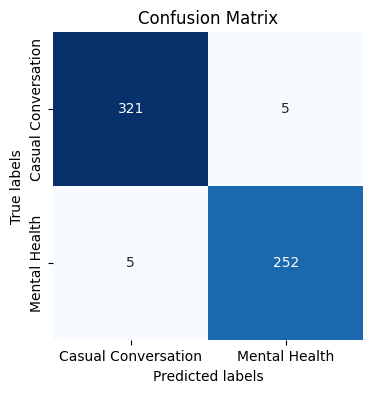

Classification Report:
                      precision    recall  f1-score   support

Casual Conversation       0.98      0.98      0.98       326
      Mental Health       0.98      0.98      0.98       257

           accuracy                           0.98       583
          macro avg       0.98      0.98      0.98       583
       weighted avg       0.98      0.98      0.98       583

F1-score for BERT model: 0.980544747081712


In [24]:
# Combine (group) predictions and probabilities from multiple children sequences into a single prediction for each post.
y_test_grouped, y_pred_grouped = combine_preds_BERT(preds_proba,id_test,X_test['target'])
create_confusion_matrix_and_class_report(y_test_grouped,y_pred_grouped,make_confusion=True)
report = create_confusion_matrix_and_class_report(y_test_grouped,y_pred_grouped,make_confusion=False,output_dict=True)
bert_f1 = report['Mental Health']['f1-score']
f1_scores['BERT'] = bert_f1
print(f'F1-score for BERT model: {bert_f1}')

### ONNX Format
For portability and ease of deployment, the model can be exported in the ONNX format. The model is saved as `BERT_reddit.onnx` in the cell below.

In [25]:
# Model save location
model_path = 'models/'
model_name = 'BERT_reddit.onnx'

# Convert the model to ONNX format
model.to('cpu')

# Extract a batch of inputs from DataLoader
batch = next(iter(test_dataloader))
input_ids_batch = batch['input_ids']
attention_mask_batch = batch['attention_mask']

torch.onnx.export(
    model,
    (input_ids_batch, attention_mask_batch),
    os.path.join(model_path,model_name),
    input_names=["input_ids", "attention_mask"],
    output_names=["output"],
    dynamic_axes={"input_ids": {0: "batch_size"}, "attention_mask": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=14
)

To use the model for inference, we can load the ONNX file as shown below.

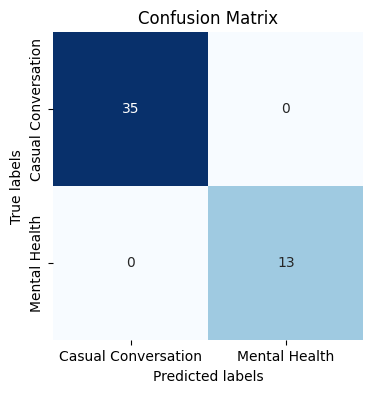

Classification Report:
                      precision    recall  f1-score   support

Casual Conversation       1.00      1.00      1.00        35
      Mental Health       1.00      1.00      1.00        13

           accuracy                           1.00        48
          macro avg       1.00      1.00      1.00        48
       weighted avg       1.00      1.00      1.00        48



In [26]:
# Model save location
model_path = 'models/'
model_name = 'BERT_reddit.onnx'

# Load the ONNX model and predict on a small batch of examples
dataset_dict = create_dataset_dict(tokenizer, X_test)
pred_dataloader = DataLoader(dataset_dict['test'], batch_size=8)
ort_session = ort.InferenceSession(os.path.join(model_path,model_name))
pred_proba = run_inference(pred_dataloader,ort_session,num_batches=5)

y_test_grouped, y_pred_grouped = combine_preds_BERT(pred_proba,id_test,X_test['target'])
create_confusion_matrix_and_class_report(y_test_grouped, y_pred_grouped,make_confusion=True)

To reduce file size, we perform quantization.

In [27]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

# Load and optimize onnx model
model_path = 'models'
onnx_name = 'BERT_reddit.onnx'
quantized_onnx_name = 'BERT_reddit_quantized.onnx'

# Quantize the model
quantize_dynamic(os.path.join(model_path,onnx_name),
                 os.path.join(model_path,quantized_onnx_name), weight_type=QuantType.QInt8)

Verify quantized model works well.

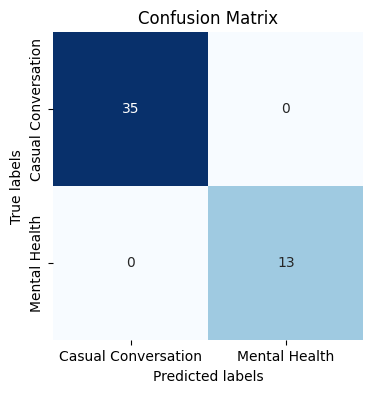

Classification Report:
                      precision    recall  f1-score   support

Casual Conversation       1.00      1.00      1.00        35
      Mental Health       1.00      1.00      1.00        13

           accuracy                           1.00        48
          macro avg       1.00      1.00      1.00        48
       weighted avg       1.00      1.00      1.00        48



In [28]:
# Model save location
model_path = 'models/'
model_name = 'BERT_reddit_quantized.onnx'

# Load the ONNX model and predict on a small batch of examples
dataset_dict = create_dataset_dict(tokenizer, X_test)
pred_dataloader = DataLoader(dataset_dict['test'], batch_size=8)
ort_session = ort.InferenceSession(os.path.join(model_path,model_name))
pred_proba = run_inference(pred_dataloader,ort_session,num_batches=5)

y_test_grouped, y_pred_grouped = combine_preds_BERT(pred_proba,id_test,X_test['target'])
create_confusion_matrix_and_class_report(y_test_grouped, y_pred_grouped,make_confusion=True)

## Evaluation and Model Comparison

We have considered traditional machine learning algorithms including multinomial Naive Bayes and logistic regression, coupled with different vectorizing text techniques. From the realm of Gradient Boosting Machines (GBM), we considered the use of XGBoost. Finally, we have also exploited a pre-trained transformer, which is a state-of-the-art Neural Network approach. Here, we compare the performance of these different models. In the context of identifying text posts displaying signs of psychological distress, we should optimize both precision and recall. For this reason, we use the F1-score in relation to identifying 'positive' posts, i.e. posts with signs of mental health concerns, as our metric for comparing the different models. The corresponding F1 scores have been collected in `f1_scores`.

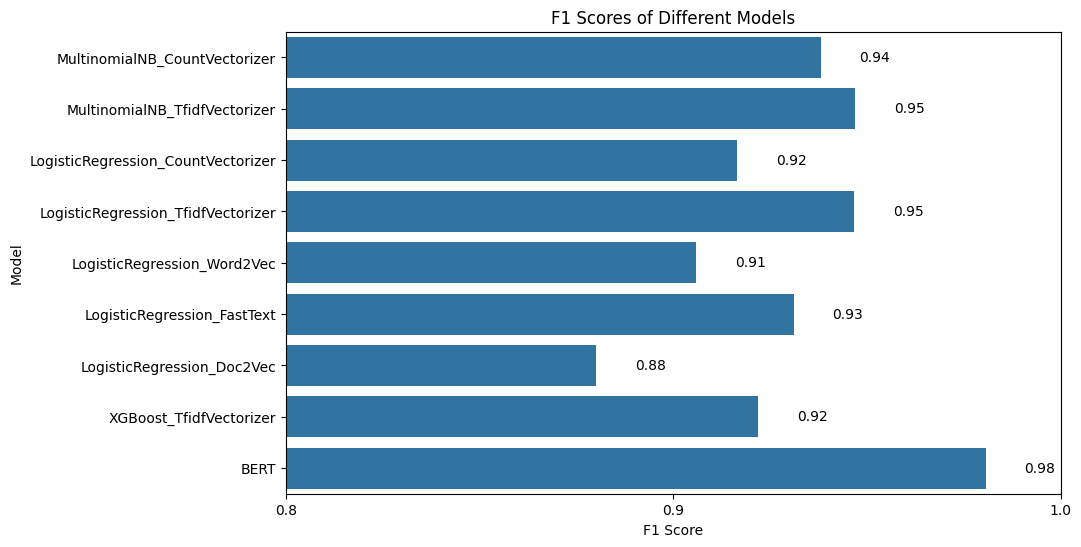

In [29]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(f1_scores.items()), columns=['Model', 'F1 Score'])

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='F1 Score', y='Model', data=df)

# Add title and labels
plt.title('F1 Scores of Different Models')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.xlim([0.8,1.0])
plt.xticks(ticks=[i/10 for i in range(8,11)], labels=[i/10 for i in range(8,11)]);

# Add F1-score text at the end of each bar
for index, value in enumerate(df['F1 Score']):
    ax.text(value + 0.01, index, f'{value:.2f}', color='black', va="center");

Taking a closer look, we compare the predicted probability values used for classification by the Multinomial NB model and the BERT model. We load and infer using the BERT model.

In [30]:
# Model save location
model_path = 'models/'
model_name = 'BERT_reddit_quantized.onnx'

# Preprocess text data for BERT and print number of samples in each category.
df = preprocess_BERT(df_raw,min_num_words=20,split_length=500)

# Train test split
X_train, X_test = train_test_split(df.drop(columns='id'), test_size=0.2,
                                   random_state=42,
                                   stratify=df['target'])                      # Train test split

# Retain ids for later reference
id_train, id_test = train_test_split(df['id'],
                                     test_size=0.2,
                                     stratify=df['target'],
                                     random_state=42)

# Load the ONNX BERT model and predict on test set
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
dataset_dict = create_dataset_dict(tokenizer, X_test)
pred_dataloader = DataLoader(dataset_dict['test'], batch_size=8)
ort_session = ort.InferenceSession(os.path.join(model_path,model_name))
pred_proba = run_inference(pred_dataloader,ort_session,num_batches=None)
y_test_grouped_BERT, y_pred_grouped_BERT_proba = combine_preds_BERT(pred_proba,id_test,X_test['target'], return_probs=True)

target
0    2988
1    1404
Name: count, dtype: int64

Then, we load and infer using the Multinomial NB model.

In [31]:
# Model save location
model_path = 'models/'
model_name = 'MultinomialNB_TfidfVectorizer.pkl'

# Preprocess text and show sample size in each category
df = preprocess_regular(df_raw, min_num_words=None,split_length=None,remove_punc=True)

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(df['alltext'],
                                                    df['target'],
                                                    test_size=0.2,
                                                    stratify=df['target'],
                                                    random_state=42)

# Retain ids for later reference if text splitting is done.
id_train, id_test = train_test_split(df['id'],
                                     test_size=0.2,
                                     stratify=df['target'],
                                     random_state=42)

# Load Multinomial NB model and predict on test set
with open(os.path.join(model_path,model_name),'rb') as f:
    MNB_tfidf = pickle.load(f)
pred_proba = MNB_tfidf.predict_proba(X_test)
y_test_grouped_MN, y_pred_grouped_MN_proba = combine_preds_regular(pred_proba,id_test,y_test,return_probs=True)

target
1    1010
0     977
Name: count, dtype: int64

We then compare the distribution of predicted probabilities when the text post is positive (i.e. showing signs of mental health distress).

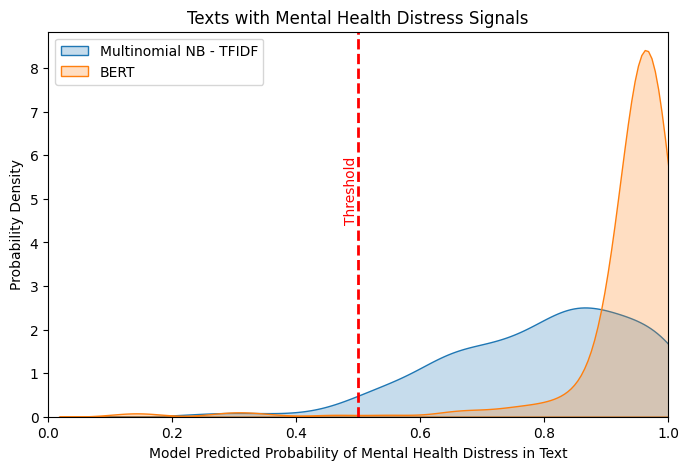

In [32]:
# Plot predicted probability density
fig, ax = plt.subplots(1,1,figsize=(8,5))
df_MN = pd.concat([y_pred_grouped_MN_proba,y_test_grouped_MN],axis=1)
df_MN = df_MN[df_MN.target==1]
df_BERT = pd.concat([y_pred_grouped_BERT_proba,y_test_grouped_BERT],axis=1)
df_BERT = df_BERT[df_BERT.target==1]
sns.kdeplot(df_MN['menhealth'],label='Multinomial NB - TFIDF',shade=True,ax=ax)
sns.kdeplot(df_BERT['menhealth'],label='BERT',shade=True,ax=ax)
ylim = ax.get_ylim()
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
ax.text(x=0.5, y=(ylim[0] + ylim[1]) / 2, s='Threshold', color='red', rotation=90, verticalalignment='bottom', horizontalalignment='right')
ax.legend()
ax.set_xlim([0,1])
ax.set_xlabel('Model Predicted Probability of Mental Health Distress in Text')
ax.set_ylabel('Probability Density')
ax.set_title('Texts with Mental Health Distress Signals');


__Findings:__

Based on the model comparison shown in the chart above, we find that:
1. The different models do not perform appreciably different from each other, with the exception of logistic regression trained on Doc2Vec.
2. BERT performs best with an F1-score of 0.97, although not by a large margin. Given the compute-intensive nature of transformer models, one might opt for simpler models such as the Multinomial NB on TF-IDF vectorizer.
3. While the Multinomial NB model lags behind BERT by just 0.02 points at 0.95, it is much less certain of its prediction, with more values near the 0.5 threshold. As shown in the probability plot above, BERT shows a much higher peak near 100% and away from the threshold, indicating a lower level of uncertainty regarding its predictions.

# Conclusion and Future Work

__Conclusion:__

As shown above, different machine learning techniques can be employed for text classification. For the current use case of identifying text posts with signs of psychological distress, model comparison does not indicate significant differences in performance. That said, a relatively small dataset of approximately 1,000 datapoints in each category was used for model training. Furthermore, relatively little pre-processing has been done, beyond the application of generic vectorizers, stemming, and stop word removals. Therefore, there is likely room for improvement for each model, depending on the use case (e.g. flagging student text posts for referral to university counselors for further action), the predictive power required (e.g. precision, recall, etc), and the computational power available for inference. A simple app is created on streamlit to illustrate possibility of deployment. This app can be found in the './app' directory and can be launched by running `streamlit run Post_Classifier.py`.

__Recommendation for future work:__

For further refinement, one could improve performance by gathering more data as the current dataset is relatively modest. Additionally, further data pre-processing will certainly be advantageous. For example, emojis are frequently used in social media and can be properly transformed to extract better contextual information. Furthermore, the texts may contain weblinks, personal sign off messages, bot-generated messages, foreign (non-English in the current context) characters, etc, which may reduce the quality of the dataset. If computational resources are adequate for deep learning approaches, one could also experiment with different pre-trained BERT models (e.g. roberta, deberta), or other architectures altogether like GPT.